In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import nltk

import gensim
from gensim import corpora, downloader
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [3]:
all_data = pd.read_csv("../data/X_train_update.csv", index_col='Unnamed: 0')
target = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col='Unnamed: 0')

In [4]:
all_data.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [5]:
sentences = all_data['designation']

In [6]:
sentences.head()

0    Olivia: Personalisiertes Notizbuch / 150 Seite...
1    Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2    Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3    Peluche Donald - Europe - Disneyland 2000 (Mar...
4                                 La Guerre Des Tuques
Name: designation, dtype: object

In [7]:
tokens = [simple_preprocess(sent, min_len = 3) for sent in sentences]

In [8]:
print(len(tokens))
print(tokens[150])

84916
['mer', 'les', 'marins', 'scènes', 'maritimes']


In [9]:
dictionary = corpora.Dictionary(tokens)

In [10]:
print("nombre de phrases traitées :", dictionary.num_docs)
print("nombre de mots traités :", dictionary.num_pos)

nombre de phrases traitées : 84916
nombre de mots traités : 696547


In [11]:
print("taille du dictionnaire : {} mots".format(len(dictionary)))

taille du dictionnaire : 60866 mots


In [12]:
size_tokens = map(lambda x:len(x),tokens)

max_len = max(size_tokens)

print("taille maximum des sequences de tokens :", max_len )

taille maximum des sequences de tokens : 33


In [13]:
embeddings_index = {}

f = open("../data/glove/glove.6B.100d.txt")

for line in f :
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coeffs 
f.close()

In [14]:
sort_dictionary = sorted(dictionary.cfs.items(), key = lambda t : -t[1])

words = [dictionary[t[0]] for t in sort_dictionary]

In [15]:
# création de la matrice d'embedding sur 100 dimensions pour les 10 000 mots les plus fréquents
embedding_dim = 100
max_words = len(dictionary)+1 # on prend tout le dicitonnaire ici

embedding_matrix = np.zeros((max_words,embedding_dim))

for  i, word in enumerate(words) :
    if i < max_words :
        embedding_vector = embeddings_index.get(word)
    
    if  embedding_vector is not None :
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix.shape

(60867, 100)

In [17]:
data = pd.Series(tokens)
data = pd.concat([data,target['prdtypecode']], axis =1)
data = data.rename(columns={ 0 : 'sequence','prdtypecode':'class' })
data.head()

,sequence,class
0,"[olivia, notizbuch, seiten, punktraster, din, ...",10
1,"[journal, des, arts, art, son, marche, salon, ...",2280
2,"[grand, stylet, ergonomique, bleu, gamepad, ni...",50
3,"[peluche, donald, europe, disneyland, marionne...",1280
4,"[guerre, des, tuques]",2705


In [18]:
# transformation des séquences de mots en séquence d'id
seq = list(data['sequence'])

id_seq = [dictionary.doc2idx(t) for t in seq]

# padding des séquences de mot du df à 33
from keras.utils import pad_sequences

id_seq_pad = pad_sequences(id_seq , maxlen =  max_len, padding = 'post')

In [19]:
id_seq_pad.shape

(84916, 33)

In [20]:
target = pd.Series(target['prdtypecode'])

In [21]:
# Split train /test 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(id_seq_pad, target, test_size=0.2, random_state = 0, stratify = target) 

In [22]:
# split test /valid 80/20
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 0, stratify = y_train) 

In [23]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y_train_label = label_encoder.fit_transform(y_train.to_numpy())
y_test_label = label_encoder.transform(y_test.to_numpy())
y_valid_label = label_encoder.transform(y_valid.to_numpy())

In [26]:
from keras.models import Sequential
from keras.layers import Embedding , Flatten, Dense, MaxPooling2D, Conv2D, Dropout

n_class = 27

# Création du modèle de classification
model = Sequential()
model.add(Embedding(input_dim = max_words, 
                    output_dim = embedding_dim, 
                    weights=[embedding_matrix],
                    input_length = max_len))
model.add(Flatten())
model.add(Dense(n_class, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 100)           6086700   
                                                                 
 flatten_1 (Flatten)         (None, 3300)              0         
                                                                 
 dense_1 (Dense)             (None, 27)                89127     
                                                                 
Total params: 6,175,827
Trainable params: 6,175,827
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer= 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
from tensorflow.keras import callbacks

# Instanciation du callback 
checkpoint = callbacks.ModelCheckpoint(filepath = "../data/checkpoint_text_embedding",
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [30]:
# entrainement du modèle
history = model.fit(X_train, y_train_label,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (X_valid,y_valid_label),
                    callbacks = [checkpoint])

Epoch 1/10
1699/1699 [==============================] - 324s 190ms/step - loss: 1.8032 - accuracy: 0.5061 - val_loss: 1.1948 - val_accuracy: 0.6654
Epoch 2/10
1699/1699 [==============================] - 314s 185ms/step - loss: 0.7815 - accuracy: 0.7785 - val_loss: 0.8801 - val_accuracy: 0.7469
Epoch 3/10
1699/1699 [==============================] - 310s 182ms/step - loss: 0.4207 - accuracy: 0.8839 - val_loss: 0.8228 - val_accuracy: 0.7661
Epoch 4/10
1699/1699 [==============================] - 308s 181ms/step - loss: 0.2252 - accuracy: 0.9424 - val_loss: 0.8345 - val_accuracy: 0.7711
Epoch 5/10
1699/1699 [==============================] - 326s 192ms/step - loss: 0.1203 - accuracy: 0.9711 - val_loss: 0.8781 - val_accuracy: 0.7673
Epoch 6/10
1699/1699 [==============================] - 326s 192ms/step - loss: 0.0696 - accuracy: 0.9841 - val_loss: 0.9306 - val_accuracy: 0.7660
Epoch 7/10
1699/1699 [==============================] - 322s 189ms/step - loss: 0.0440 - accuracy: 0.9901 - val_

In [57]:
from joblib import dump, load

dump(model, "../models/model_texte_embedding_100.joblib")
dump(model, "../models/model_texte_embedding_100.pkl")


INFO:tensorflow:Assets written to: ram://60d07c49-67b8-4818-b1f1-6c6397d8016a/assets
INFO:tensorflow:Assets written to: ram://6333e9fc-2f0c-4e14-b677-d6b5fb893b7b/assets


['../models/model_texte_embedding_100.pkl']

In [32]:
model.evaluate(X_test, y_test_label)

531/531 [==============================] - 1s 1ms/step - loss: 1.1506 - accuracy: 0.7661


[1.150564432144165, 0.7661328315734863]

In [58]:


model_test = load( "../models/model_texte_embedding_100.joblib")

In [59]:
model_test.evaluate(X_test, y_test_label)

531/531 [==============================] - 1s 1ms/step - loss: 1.1506 - accuracy: 0.7661


[1.150564432144165, 0.7661328315734863]

In [33]:
# Récupération de l'accuray 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [34]:
epochs = range(1, len(acc)+1)

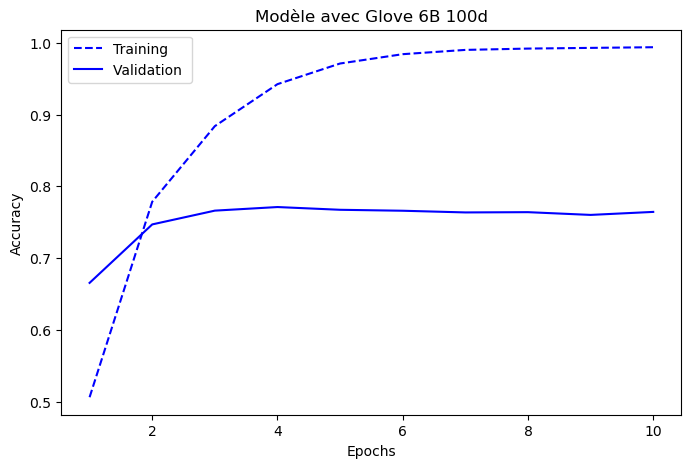

In [35]:
plt.figure(figsize = (8,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Modèle avec Glove 6B 100d")

plt.plot(epochs,acc, "b--", label = "Training" )
plt.plot(epochs,val_acc,"b",label = "Validation ")

plt.legend();